In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import stitch
import utils
import features

In [2]:
capture1 = cv2.VideoCapture(0)
capture2 = cv2.VideoCapture(1)

ref1, frame1 = capture1.read()
ref2, frame2 = capture2.read()
print(type(ref1), ref1, type(frame1), type(ref2), ref2, type(frame2))

<class 'bool'> True <class 'numpy.ndarray'> <class 'bool'> True <class 'numpy.ndarray'>


In [3]:
def convertResult(img):
    '''Because of your images which were loaded by opencv, 
    in order to display the correct output with matplotlib, 
    you need to reduce the range of your floating point image from [0,255] to [0,1] 
    and converting the image from BGR to RGB:'''
    img = np.array(img,dtype=float)/float(255)
    img = img[:,:,::-1]
    return img

<class 'bool'> True <class 'numpy.ndarray'> <class 'bool'> True <class 'numpy.ndarray'>


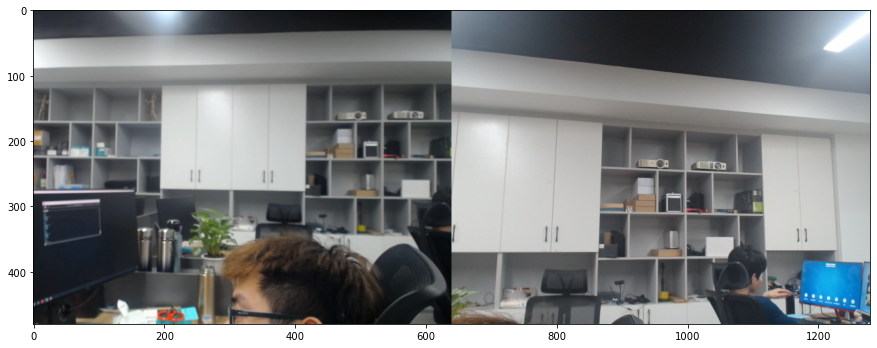

In [4]:
ref1, frame1 = capture1.read()
ref2, frame2 = capture2.read()
print(type(ref1), ref1, type(frame1), type(ref2), ref2, type(frame2))
plt_img = np.concatenate((frame1, frame2), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(convertResult(plt_img))

In [5]:
pano, non_blend, left_side, right_side = stitch.warpTwoImages(frame2, frame1, True)

识别位置过于小 自动扩宽 YL


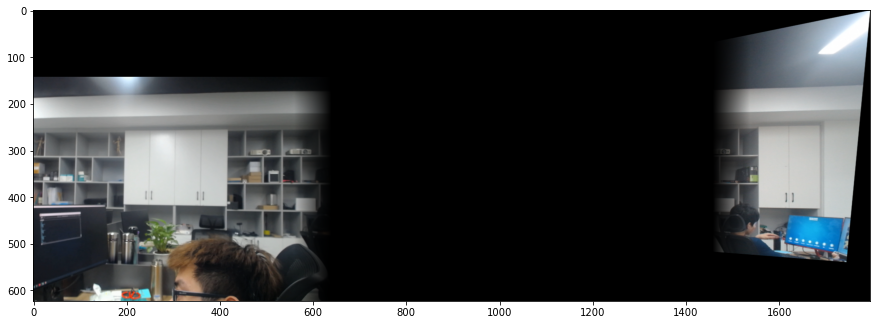

In [6]:
plt_img = np.concatenate((left_side, right_side), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(convertResult(plt_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


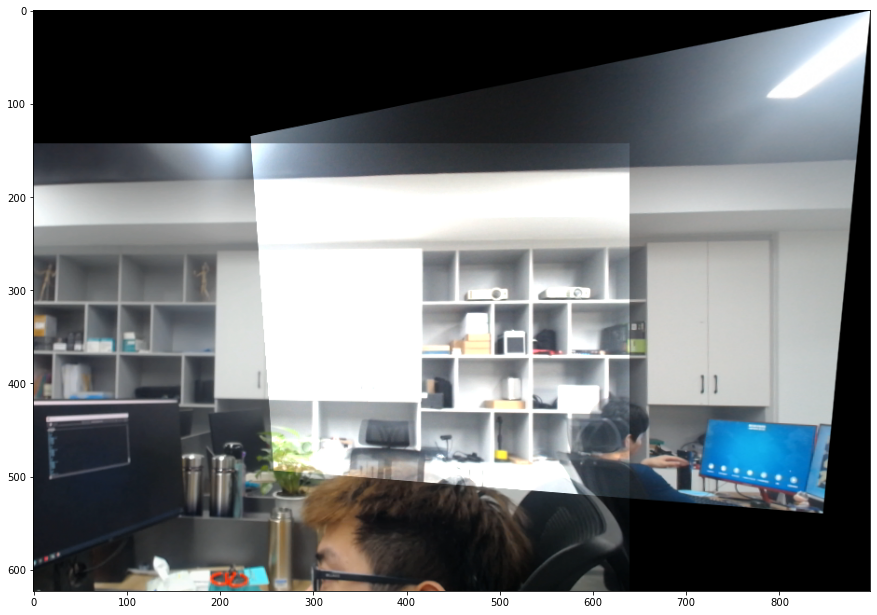

In [10]:
print(type(non_blend))
plt.figure(figsize=(15,15))
plt.imshow(convertResult(non_blend))

<class 'numpy.ndarray'>


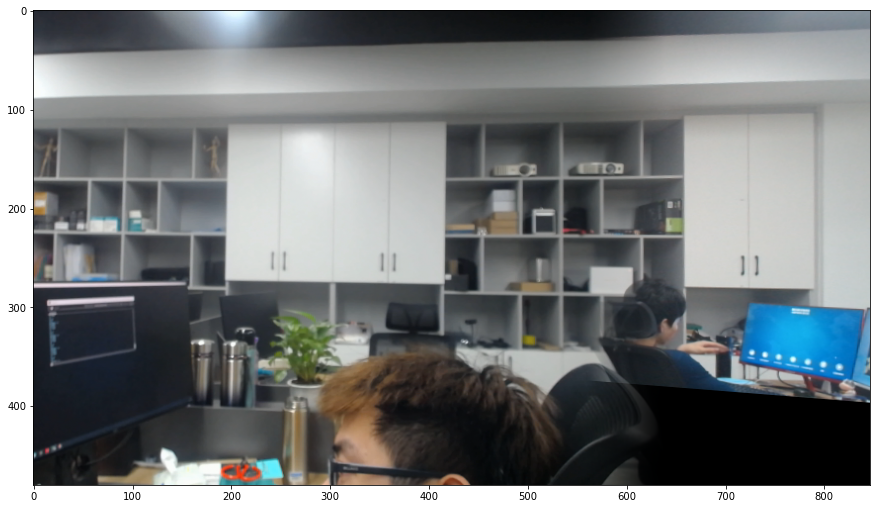

In [9]:
print(type(pano))
plt.figure(figsize=(15,15))
plt.imshow(convertResult(pano))

In [11]:
img = np.array(pano,dtype=float)/float(255)
cv2.imshow("tu1", convertResult(img))
while True:
    if cv2.waitKey(30) > 0:
        break

KeyboardInterrupt: 

In [1]:
def warpTwoImages2(src_img, dst_img, showstep=False):

    # generate Homography matrix
    H, _ = features.generateHomography(src_img, dst_img)

    # get height and width of two images
    height_src, width_src = src_img.shape[:2]
    height_dst, width_dst = dst_img.shape[:2]

    # extract conners of two images: top-left, bottom-left, bottom-right, top-right
    pts1 = np.float32(
        [[0, 0], [0, height_src], [width_src, height_src], [width_src, 0]]
    ).reshape(-1, 1, 2)
    pts2 = np.float32(
        [[0, 0], [0, height_dst], [width_dst, height_dst], [width_dst, 0]]
    ).reshape(-1, 1, 2)

    try:
        print(" ------1------- ")
        # aply homography to conners of src_img
        pts1_ = cv2.perspectiveTransform(pts1, H)
        pts = np.concatenate((pts1_, pts2), axis=0)

        # find max min of x,y coordinate
        [xmin, ymin] = np.int64(pts.min(axis=0).ravel() - 0.5)
        [_, ymax] = np.int64(pts.max(axis=0).ravel() + 0.5)
        t = [-xmin, -ymin]
        print(" ------2------- ")
        # top left point of image which apply homography matrix, which has x coordinate < 0, has side=left
        # otherwise side=right
        # source image is merged to the left side or right side of destination image
        if pts[0][0][0] < 0:
            side = "left"
            width_pano = width_dst + t[0]
        else:
            width_pano = int(pts1_[3][0][0])
            side = "right"
        height_pano = ymax - ymin
        
#         dst_img_rz_size_H = dst_img.shape[0]
#         dst_img_rz_size_W = dst_img.shape[1]
#         if height_pano < dst_img_rz_size_H:
#             height_pano = dst_img_rz_size_H
#         if width_pano < dst_img_rz_size_W:
#             width_pano = dst_img_rz_size_W
        
        print(" ------3------- ")
        # Translation
        # https://stackoverflow.com/a/20355545
        Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
        src_img_warped = cv2.warpPerspective(
            src_img, Ht.dot(H), (width_pano, height_pano)
        )
        print(" ------4------- ")
        
        
        
        # generating size of dst_img_rz which has the same size as src_img_warped
#         dst_img_rz = np.zeros((height_pano, width_pano, 3))
   
        
        
        if side == "left":
            dst_img_rz = np.zeros((height_src + t[1], width_dst + t[0], 3))
            dst_img_rz[t[1] : height_src + t[1], t[0] : width_dst + t[0]] = dst_img
        else:
            dst_img_rz = np.zeros((height_src + t[1], width_dst, 3))
            dst_img_rz[t[1] : height_src + t[1], :width_dst] = dst_img
            
        print(" ------7------- ")
        # blending panorama
        pano, nonblend, leftside, rightside = stitch.panoramaBlending(
            dst_img_rz, src_img_warped, width_dst, side, showstep=showstep
        )
        print(" ------8------- ")
        # croping black region
        pano = stitch.crop(pano, height_dst, pts)
        return pano, nonblend, leftside, rightside
    except BaseException as e:
        raise Exception("Please try again with another image set!",e)

In [2]:
pano, non_blend, left_side, right_side = warpTwoImages2(frame2, frame1, True)

NameError: name 'frame2' is not defined

In [34]:
#load images
list_images=utils.loadImages('data/myhouse',resize=0)

In [75]:
# src_img = list_images[1]
# dst_img = list_images[0]

src_img = frame2
dst_img = frame1


In [76]:
# generate Homography matrix
H, _ = features.generateHomography(src_img, dst_img)

# get height and width of two images
height_src, width_src = src_img.shape[:2]
height_dst, width_dst = dst_img.shape[:2]

# extract conners of two images: top-left, bottom-left, bottom-right, top-right
pts1 = np.float32(
    [[0, 0], [0, height_src], [width_src, height_src], [width_src, 0]]
).reshape(-1, 1, 2)
pts2 = np.float32(
    [[0, 0], [0, height_dst], [width_dst, height_dst], [width_dst, 0]]
).reshape(-1, 1, 2)

In [91]:
# generate Homography matrix
H, _ = features.generateHomography(src_img, dst_img)
showstep=False
# get height and width of two images
height_src, width_src = src_img.shape[:2]
height_dst, width_dst = dst_img.shape[:2]

# extract conners of two images: top-left, bottom-left, bottom-right, top-right
pts1 = np.float32(
    [[0, 0], [0, height_src], [width_src, height_src], [width_src, 0]]
).reshape(-1, 1, 2)
pts2 = np.float32(
    [[0, 0], [0, height_dst], [width_dst, height_dst], [width_dst, 0]]
).reshape(-1, 1, 2)


print(" ------1------- ")
# aply homography to conners of src_img
pts1_ = cv2.perspectiveTransform(pts1, H)
pts = np.concatenate((pts1_, pts2), axis=0)

# find max min of x,y coordinate
[xmin, ymin] = np.int64(pts.min(axis=0).ravel() - 0.5)
[_, ymax] = np.int64(pts.max(axis=0).ravel() + 0.5)
t = [-xmin, -ymin]
print(" ------2------- ")
# top left point of image which apply homography matrix, which has x coordinate < 0, has side=left
# otherwise side=right
# source image is merged to the left side or right side of destination image
if pts[0][0][0] < 0:
    side = "left"
    width_pano = width_dst + t[0]
else:
    width_pano = int(pts1_[3][0][0])
    side = "right"
height_pano = ymax - ymin
print(" ------3------- ")
# Translation
# https://stackoverflow.com/a/20355545
Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
src_img_warped = cv2.warpPerspective(
    src_img, Ht.dot(H), (width_pano, height_pano)
)
print(" ------4------- ")

dst_img_rz_size_H = dst_img.shape[0]
dst_img_rz_size_W = dst_img.shape[1]
if height_pano < dst_img_rz_size_H:
    height_pano = dst_img_rz_size_H
if width_pano < dst_img_rz_size_W:
    width_pano = dst_img_rz_size_W

# generating size of dst_img_rz which has the same size as src_img_warped
dst_img_rz = np.zeros((height_pano, width_pano, 3))



if side == "left":
    dst_img_rz[t[1] : height_src + t[1], t[0] : width_dst + t[0]] = dst_img
else:
    dst_img_rz[t[1] : height_src + t[1], :width_dst] = dst_img
    
dst_img_rz = np.zeros((height_pano, width_pano, 3))
print(" ------6-------side ",side)
print(" ------6-------height_src ",height_src)
print(" ------6-------width_dst ",width_dst)
print(" ------6-------t ",t[1], t[0])
print(" ------dst_img_rz-------t ",dst_img_rz.shape,"   ",height_pano, width_pano, 3)


 ------1------- 
 ------2------- 
 ------3------- 
 ------4------- 
 ------6-------side  right
 ------6-------height_src  480
 ------6-------width_dst  640
 ------6-------t  0 0
 ------dst_img_rz-------t  (480, 640, 3)     480 640 3


In [92]:
print(" ------7------- ")
# blending panorama
pano, nonblend, leftside, rightside = stitch.panoramaBlending(
    dst_img_rz, src_img_warped, width_dst, side, showstep=showstep
)
print(" ------8------- ")
# croping black region
pano = stitch.crop(pano, height_dst, pts)

 ------7------- 


ValueError: operands could not be broadcast together with shapes (480,245,3) (480,640,3) 

In [79]:
dst_img_rz[t[1] : height_src + t[1], :width_dst] = dst_img

In [80]:
print(t[1] , height_src , t[1], width_dst)
print(dst_img_rz.shape)
print(dst_img.shape)

0 480 0 640
(480, 640, 3)
(480, 640, 3)


In [81]:
648+87+87,968+87

(822, 1055)

ValueError: could not broadcast input array from shape (480,640,3) into shape (480,500,3)

In [83]:
dst_img_rz3 = np.zeros((480, 500, 3))
dst_img_rz3[0 : 480 + 0, :640] = dst_img  # (480, 640, 3)

ValueError: could not broadcast input array from shape (480,640,3) into shape (480,500,3)

In [70]:
dst_img_rz_size_H = dst_img.shape

In [71]:
dst_img_rz_size_H

(648, 968, 3)

In [72]:
dst_img_rz_size_H[0]

648

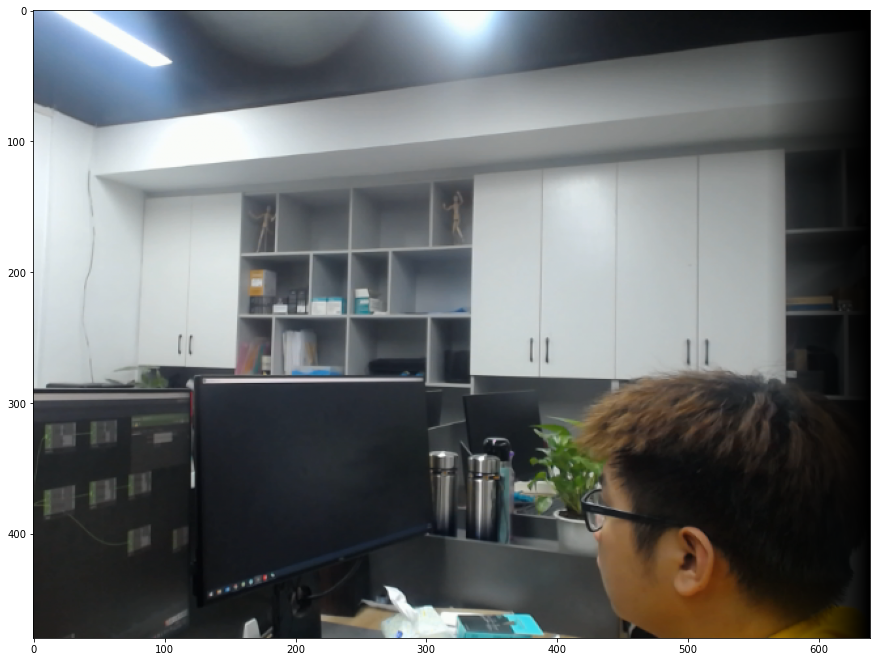

In [95]:
#display the leftside of pano before cropping
plt.figure(figsize=(15,15))
plt.imshow(convertResult(left_side))

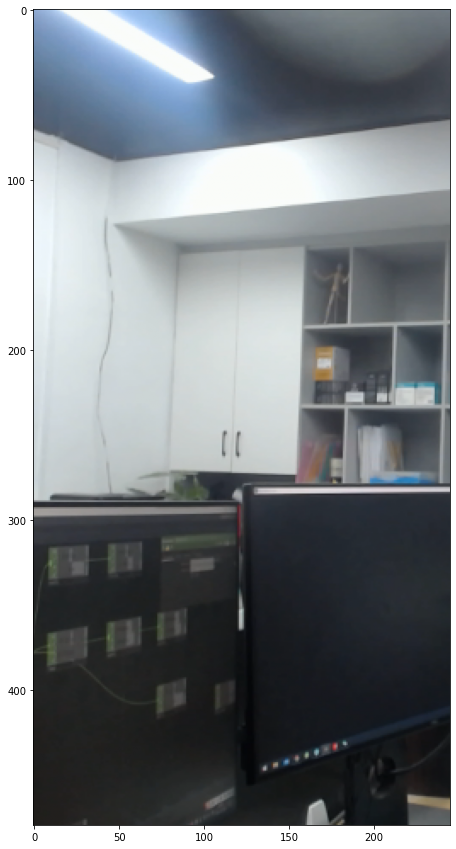

In [96]:
#display the leftside of pano before cropping
plt.figure(figsize=(15,15))
plt.imshow(convertResult(pano))